## Lorenz

In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
from utils import *
np.random.seed(0)

#
#
noise_percent = 5
#
#

Populating the interactive namespace from numpy and matplotlib


### Generate data

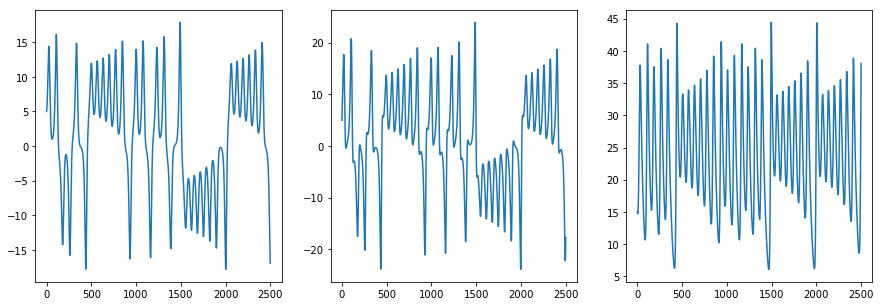

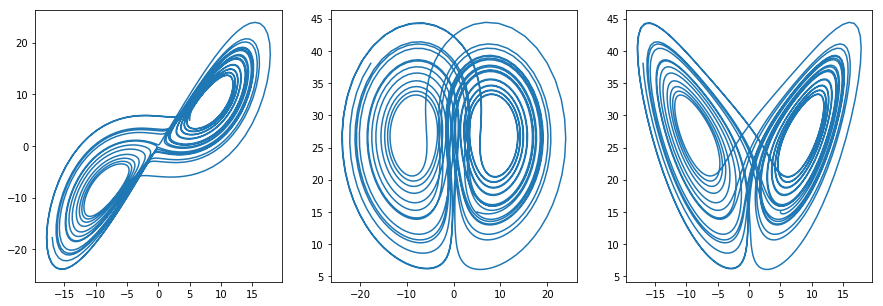

In [2]:
def lorenz_ode(X, t, params):
    
    s,r,b = params
    x,y,z = X

    return [s*(y-x), x*(r-z)-y, x*y-b*z]

M = 25000
subsample_rate = 10

subsample = [j for j in range(M) if j%subsample_rate == 0]
m = len(subsample)

t = np.linspace(0,25,M+1)[:-1]; dt = (t[1]-t[0])*subsample_rate


params = (10,28,8.0/3)
X = odeint(lorenz_ode, [5,5,15], t, args=(params,), rtol = 1e-12, atol = 1e-12)[subsample, :].T
x = X[0,:]; y = X[1,:]; z = X[2,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(x)
subplot(1,3,2); plot(y)
subplot(1,3,3); plot(z)
figure()
subplot(1,3,1); plot(x, y)
subplot(1,3,2); plot(y, z)
subplot(1,3,3); plot(x, z)

In [3]:
n = X.shape[0]
noise_level = [0.01*noise_percent*np.std(X[j,:]) for j in range(n)]
measurement_noise = np.vstack([noise_level[j]*np.random.randn(m) for j in range(n)])

Y = X + measurement_noise

In [4]:
N_hat, X_hat = approximate_noise(Y, lam = 1e2)

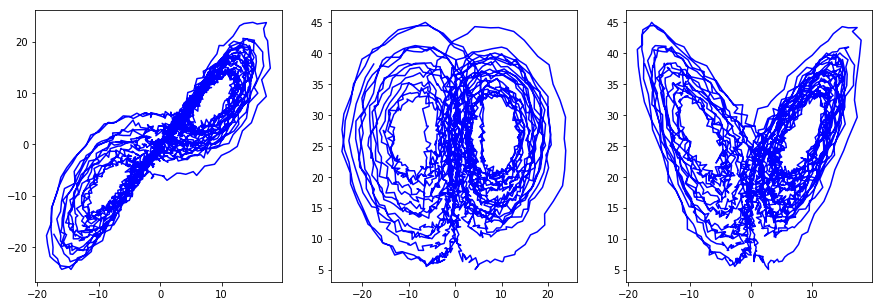

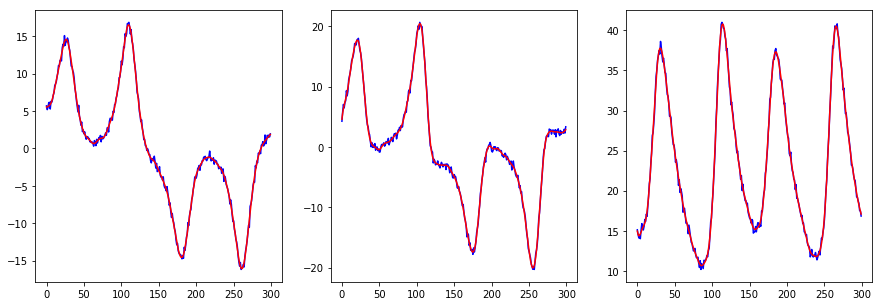

In [5]:
figure(figsize = (15,5))
subplot(1,3,1); plot(Y[0,:], Y[1,:], 'b')
subplot(1,3,2); plot(Y[1,:], Y[2,:], 'b')
subplot(1,3,3); plot(Y[0,:], Y[2,:], 'b')

figure(figsize = (15,5))
subplot(1,3,1); plot(Y[0,:300],'b'); plot(X_hat[0,:300],'r')
subplot(1,3,2); plot(Y[1,:300],'b'); plot(X_hat[1,:300],'r')
subplot(1,3,3); plot(Y[2,:300],'b'); plot(X_hat[2,:300],'r')

### Train 

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

In [7]:
if True: 
    
    saver = tf.train.Saver()
    saver.restore(sess, "./saved_sessions/Lorenz_5_gaussian.ckpt")
    
else:

    num_dt = 10

    feed_dict = {placeholders['Y_0']: Y[:,num_dt:m-num_dt], 
                 placeholders['T_0']: (np.arange(m-2*num_dt)*dt).reshape(1,m-2*num_dt),
                 placeholders['h']: np.array([[dt]])}

    for j in range(num_dt):
        feed_dict[placeholders['true_forward_Y'][j]] = Y[:,num_dt+j+1:m-num_dt+j+1]
        feed_dict[placeholders['true_backward_Y'][j]] = Y[:,num_dt-j-1:m-num_dt-j-1]

    optimizer.minimize(sess, feed_dict=feed_dict)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.007041
  Number of iterations: 15312
  Number of functions evaluations: 16522


In [8]:
X_test = np.zeros((3,5*m))
X_test[:,0] = X[:,0]

weights, biases, N = net_params

x_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    X_test[:,j+1] = sess.run(x_next_test, feed_dict={placeholders['Y_0']: np.array([X_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

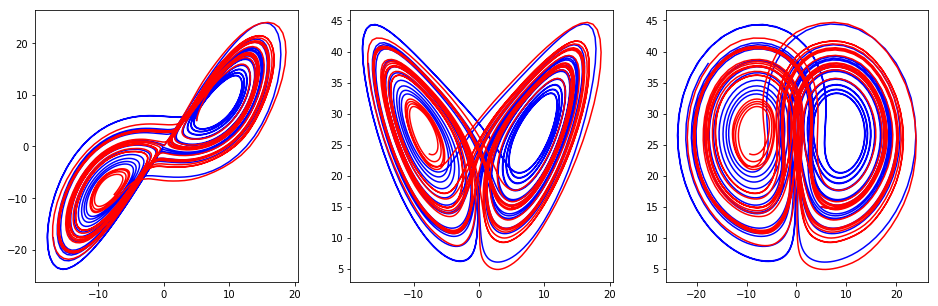

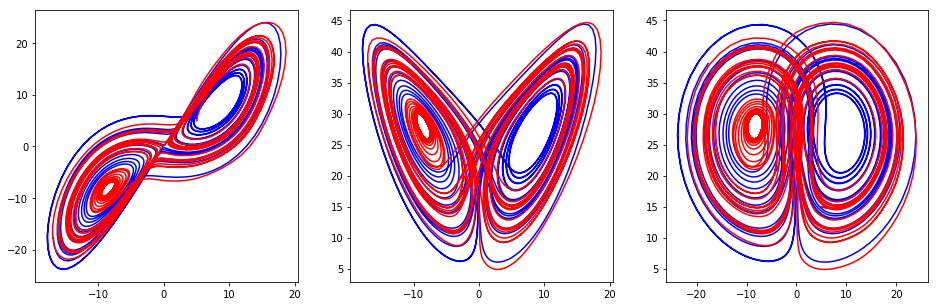

In [9]:
figure(figsize=(16,5))
subplot(1,3,1); plot(X[0,:m],X[1,:m],'b'); plot(X_test[0,:m],X_test[1,:m],'r')
subplot(1,3,2); plot(X[0,:m],X[2,:m],'b'); plot(X_test[0,:m],X_test[2,:m],'r')
subplot(1,3,3); plot(X[1,:m],X[2,:m],'b'); plot(X_test[1,:m],X_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(X[0,:m],X[1,:m],'b'); plot(X_test[0,:],X_test[1,:],'r')
subplot(1,3,2); plot(X[0,:m],X[2,:m],'b'); plot(X_test[0,:],X_test[2,:],'r')
subplot(1,3,3); plot(X[1,:m],X[2,:m],'b'); plot(X_test[1,:],X_test[2,:],'r')

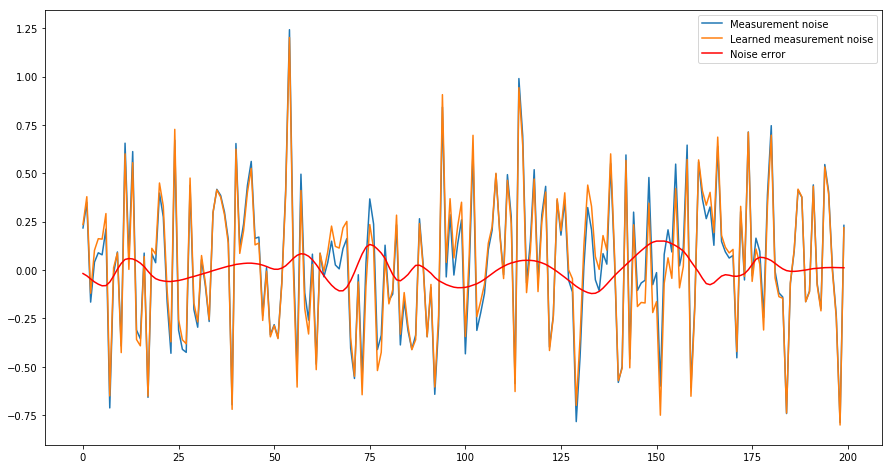

In [10]:
start = 1000
end = 1200

figure(figsize = (15,8))

plot(measurement_noise[0,start:end], label = 'Measurement noise')
plot(N.eval()[0,start:end], label = 'Learned measurement noise')
plot(measurement_noise[0,start:end] - N.eval()[0,start:end], 'r', label = 'Noise error')
legend(loc='upper right')

In [11]:
N_gaussian = N.eval()

In [11]:
if False: 
    saver = tf.train.Saver()
    saver.save(sess, "./saved_sessions/Lorenz_5_gaussian.ckpt")

In [12]:
true_vector_field = np.stack([10*(y-x), x*(28-z)-y, x*y-8/3*z], axis = 0)
approx_vec_field = sess.run(simple_net(placeholders['Y_0'], weights, biases), feed_dict = {placeholders['Y_0']: X})

noise_error = np.linalg.norm(measurement_noise - N.eval(),'fro')**2 / m
vector_field_error = np.linalg.norm(true_vector_field - approx_vec_field,'fro')**2 / np.linalg.norm(true_vector_field,'fro')**2

print(noise_error)
print(vector_field_error)

0.0266983780012
0.00198843298138


In [12]:
noise_level = 0.01*noise_percent*np.std(X)

measurement_noise_sdt = np.random.standard_t(10, size=(3,m))
measurement_noise_sdt = measurement_noise_sdt / np.std(measurement_noise_sdt)
measurement_noise_sdt = noise_level*measurement_noise_sdt

Y = X + measurement_noise_sdt
print(np.std(measurement_noise_sdt))

0.673823157399


In [13]:
N_hat, X_hat = approximate_noise(Y, lam = 1e2)

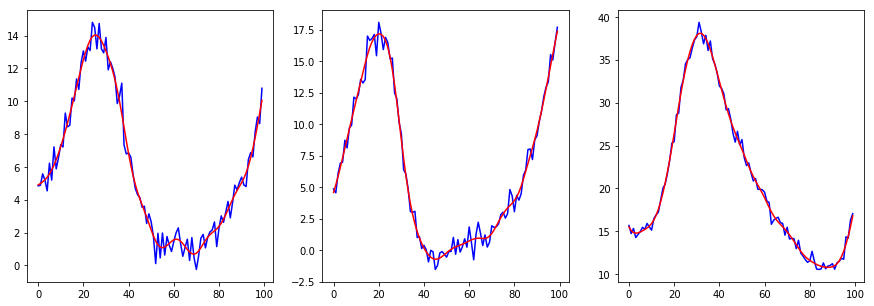

In [14]:
figure(figsize = (15,5))
subplot(1,3,1); plot(Y[0,:100],'b'); plot(X_hat[0,:100],'r')
subplot(1,3,2); plot(Y[1,:100],'b'); plot(X_hat[1,:100],'r')
subplot(1,3,3); plot(Y[2,:100],'b'); plot(X_hat[2,:100],'r')

### Train 

In [15]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

In [16]:
num_dt = 10

feed_dict = {placeholders['Y_0']: Y[:,num_dt:m-num_dt], 
             placeholders['T_0']: (np.arange(m-2*num_dt)*dt).reshape(1,m-2*num_dt),
             placeholders['h']: np.array([[dt]])}

for j in range(num_dt):
    feed_dict[placeholders['true_forward_Y'][j]] = Y[:,num_dt+j+1:m-num_dt+j+1]
    feed_dict[placeholders['true_backward_Y'][j]] = Y[:,num_dt-j-1:m-num_dt-j-1]

optimizer.minimize(sess, feed_dict=feed_dict)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.017478
  Number of iterations: 15327
  Number of functions evaluations: 16577


In [17]:
X_test = np.zeros((3,5*m))
X_test[:,0] = X[:,0]

weights, biases, N = net_params

x_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    X_test[:,j+1] = sess.run(x_next_test, feed_dict={placeholders['Y_0']: np.array([X_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

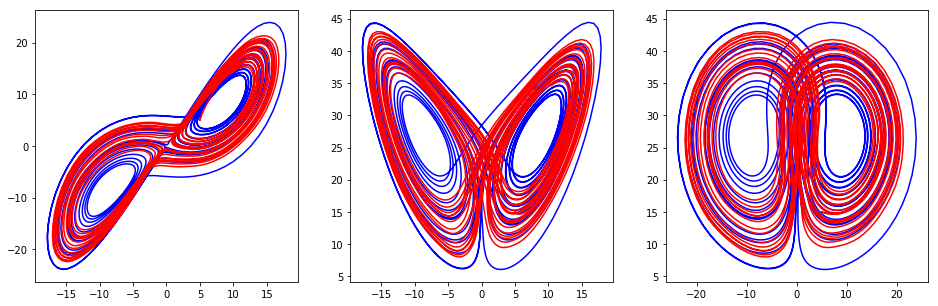

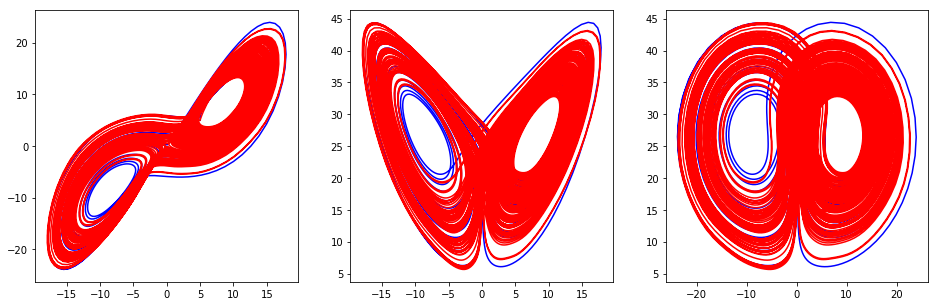

In [18]:
figure(figsize=(16,5))
subplot(1,3,1); plot(X[0,:m],X[1,:m],'b'); plot(X_test[0,:m],X_test[1,:m],'r')
subplot(1,3,2); plot(X[0,:m],X[2,:m],'b'); plot(X_test[0,:m],X_test[2,:m],'r')
subplot(1,3,3); plot(X[1,:m],X[2,:m],'b'); plot(X_test[1,:m],X_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(X[0,:m],X[1,:m],'b'); plot(X_test[0,:],X_test[1,:],'r')
subplot(1,3,2); plot(X[0,:m],X[2,:m],'b'); plot(X_test[0,:],X_test[2,:],'r')
subplot(1,3,3); plot(X[1,:m],X[2,:m],'b'); plot(X_test[1,:],X_test[2,:],'r')

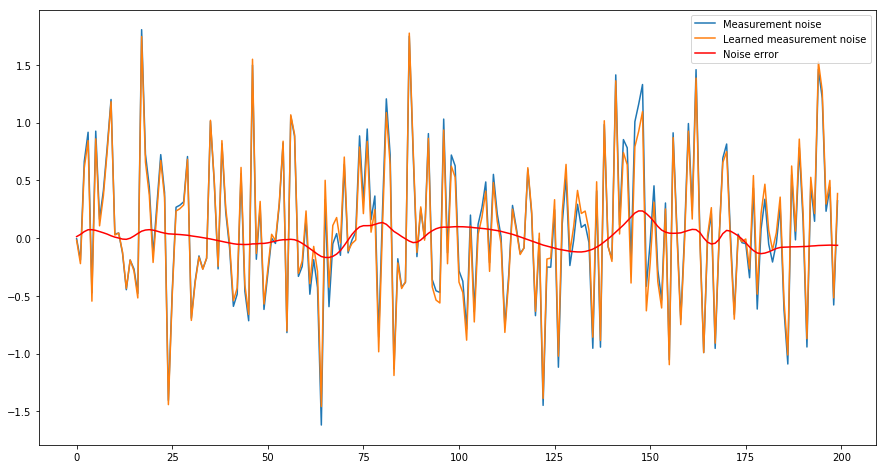

In [19]:
start = 1000
end = 1200

figure(figsize = (15,8))

plot(measurement_noise_sdt[0,start:end], label = 'Measurement noise')
plot(N.eval()[0,start:end], label = 'Learned measurement noise')
plot(measurement_noise_sdt[0,start:end] - N.eval()[0,start:end], 'r', label = 'Noise error')
legend(loc='upper right')

In [20]:
N_sdt = N.eval()

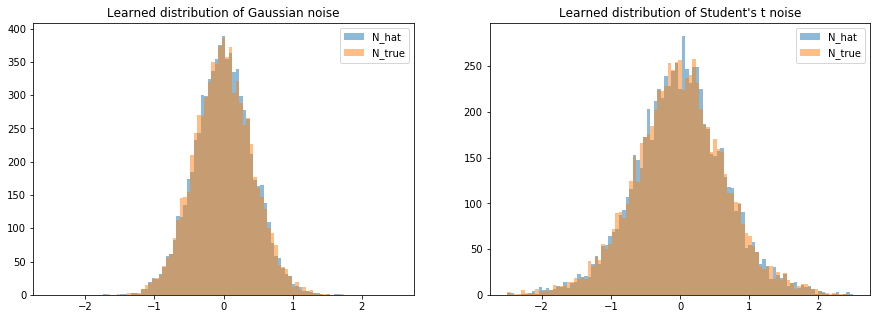

In [21]:
figure()

bins = numpy.linspace(-2.5, 2.5, 100)

subplot(1,2,1)
hist(N_gaussian.flatten(), bins, alpha=0.5, label='N_hat')
hist(measurement_noise.flatten(), bins, alpha=0.5, label='N_true')
legend(loc='upper right')
title('Learned distribution of Gaussian noise')

subplot(1,2,2)
hist(N_sdt.flatten(), bins, alpha=0.5, label='N_hat')
hist(measurement_noise_sdt.flatten(), bins, alpha=0.5, label='N_true')
legend(loc='upper right')
title('Learned distribution of Student\'s t noise')